# __Import libraries__

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os, random
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split

sns.set_theme(style="dark")

# __Simple EDA on dataset__

In [9]:
# folder path
dir_path = "BarkVN-50/BarkVN-50_mendeley"
number_of_classes = 0
classes = []
samples_number = 0
images_path = []
images_class = []
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    sub_dir = os.path.join(dir_path, path)
    if os.path.isdir(sub_dir):
        classes.append(path)
        number_of_classes += 1
        dataset_size = len(os.listdir(sub_dir))
        samples_number += dataset_size
        for image_file in os.listdir(sub_dir):
            image_file_path = os.path.join(sub_dir, image_file)
            if os.path.isfile(image_file_path):
                images_path.append(image_file_path)
                images_class.append(sub_dir)
            
print('Number of classes:', number_of_classes)
print('Number of samples:', samples_number)

Number of classes: 50
Number of samples: 5578


## Create training ans test data.

In [164]:
X_train, X_test, y_train, y_test = train_test_split(images_path, images_class, test_size=0.3, random_state=42)
train_data = pd.DataFrame({"image": X_train, "label": y_train})
test_data = pd.DataFrame({"image": X_test, "label": y_test})

## Randomly plot one image from each classes

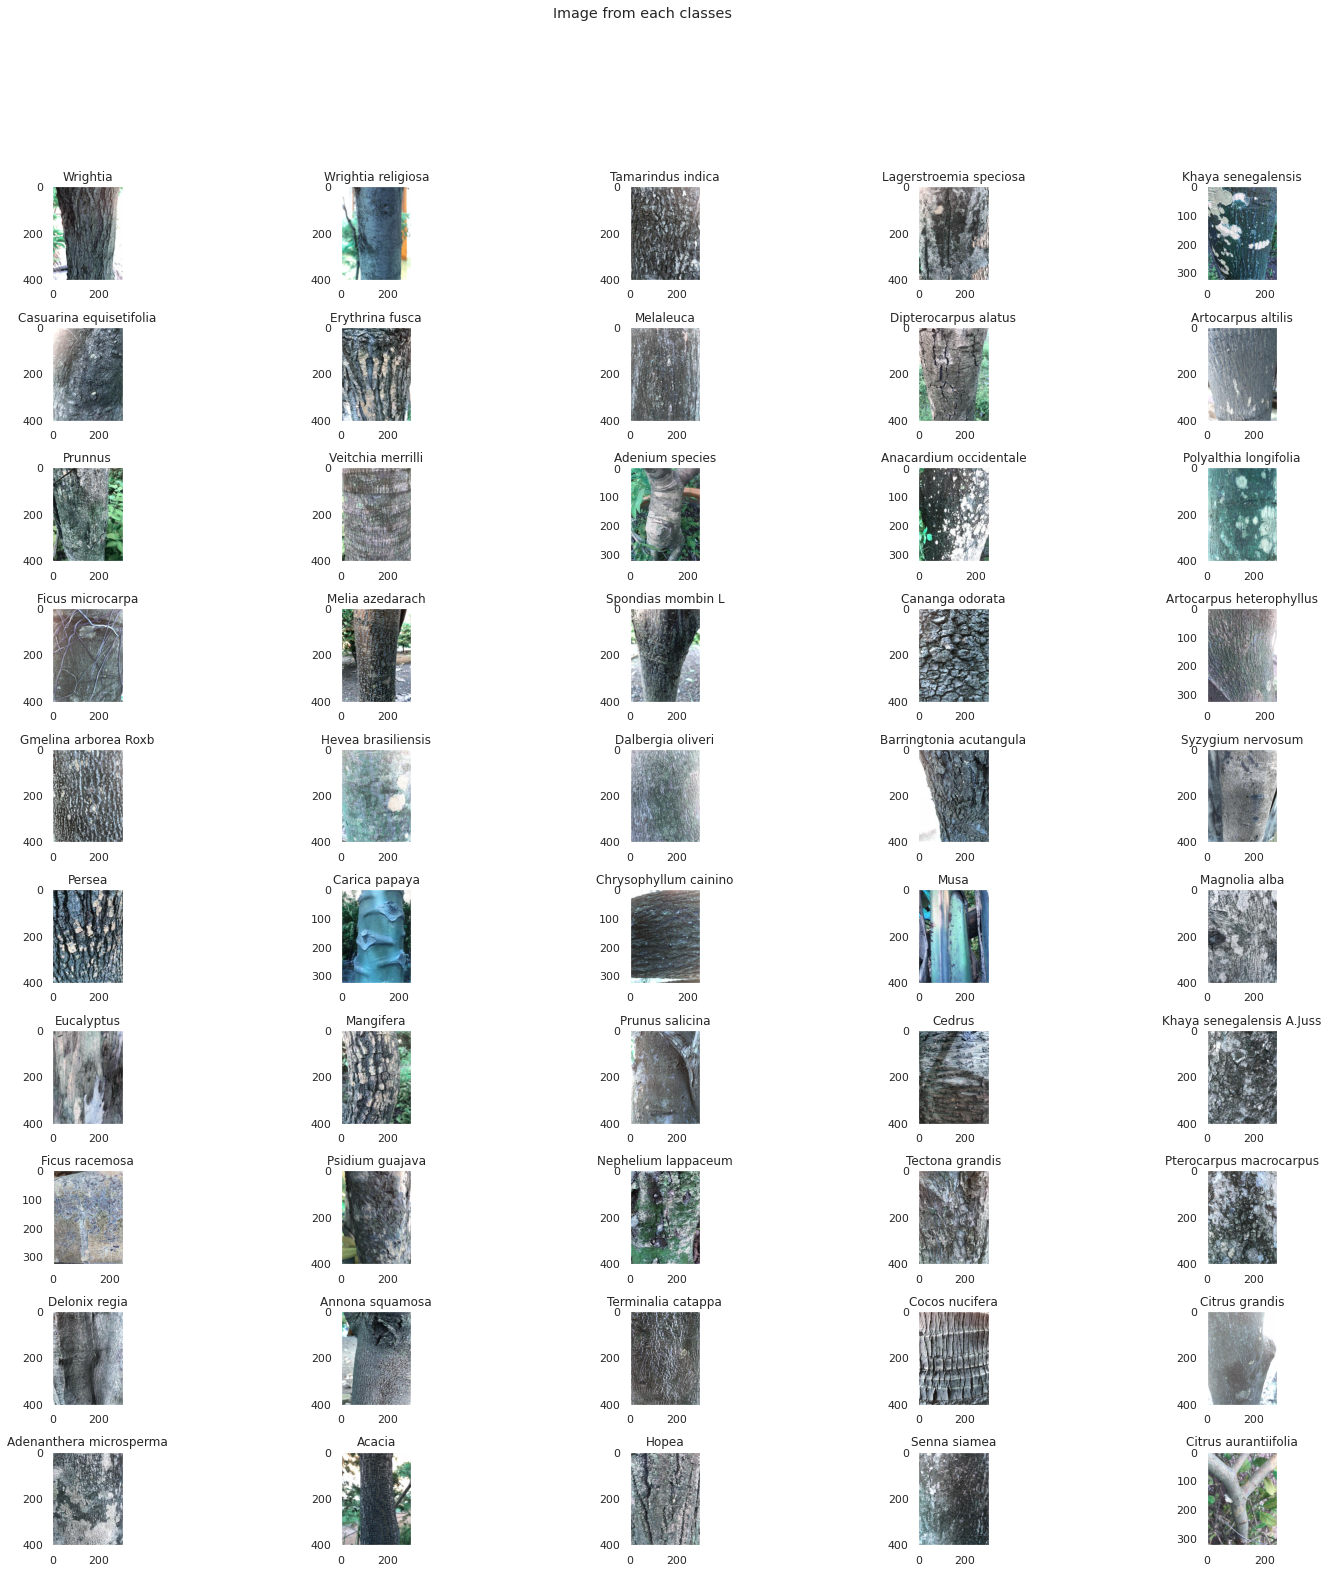

In [165]:
fig, axs = plt.subplots(10, 5, figsize=(25, 25))
fig.suptitle('Image from each classes')
plt.subplots_adjust(hspace=0.5)

for (ax, class_name) in zip(axs.flat, classes):
    ax.set_title(class_name)
    image_path = os.path.join(dir_path, class_name)
    
    image = random.choice(os.listdir(image_path))
    ax.imshow(cv2.imread(os.path.join(image_path, image)))

In [166]:
# images size
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 3

#### In this notebook i will use a pretrained model efficient net B0 from keras application 
#### Add global average pooling and batch normalisation layer on top
#### For the loss function we will use categorical cross entropy
#### and for the optimizer adam
#### For tha data preprocessing we will use a build in tensorflow utility call Datagenerator

In [167]:
# Load pretrained model
model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
)

In [168]:
# Freeze the pretrained weights
model.trainable = False

inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Rebuild top
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = tf.keras.layers.Dense(number_of_classes, activation="softmax", name="pred")(x)

# Compile
model = tf.keras.Model(model.input, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.AUC(from_logits=True)]
)

In [169]:
# Create data generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    dtype=None
)

In [170]:
# Train datagenerator
datagen_flow_train = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=None,
    x_col='image',
    y_col='label',
    weight_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='jpg',
    subset=None,
    interpolation='nearest',
    validate_filenames=True
)

# Test data generator
datagen_flow_test = datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=None,
    x_col='image',
    y_col='label',
    weight_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='jpg',
    subset=None,
    interpolation='nearest',
    validate_filenames=True
)

Found 3904 validated image filenames belonging to 50 classes.
Found 1674 validated image filenames belonging to 50 classes.


# Train model with callback function

### EarlyStopping : Stop training when a monitored metric has stopped improving.

### TensorBoard : Enable visualizations

In [175]:
# Train model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model.fit(datagen_flow_train, epochs=EPOCHS, callbacks=[callback, tensorboard_callback])

2022-09-26 16:47:42.844861: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-26 16:47:42.844934: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-09-26 16:47:42.846187: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/3
  1/122 [..............................] - ETA: 2:48 - loss: 0.8785 - accuracy: 0.8750 - auc_2: 0.9841

2022-09-26 16:47:44.747824: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-26 16:47:44.748085: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/122 [..............................] - ETA: 1:32 - loss: 0.4439 - accuracy: 0.9375 - auc_2: 0.9921

2022-09-26 16:47:45.486342: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-26 16:47:45.492568: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-09-26 16:47:45.497272: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_09_26_16_47_45

2022-09-26 16:47:45.499829: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2022_09_26_16_47_45/08a5dc0751d3.trace.json.gz
2022-09-26 16:47:45.516619: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_09_26_16_47_45

2022-09-26 16:47:45.520202: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2022_09_26_16_47_45/08a5dc0751d3.memory_profile.json.gz
2022-09-26 16:47:45.5

122/122 [==============================] - 73s 590ms/step - loss: 0.1905 - accuracy: 0.9539 - auc_2: 0.9929
Epoch 2/3
122/122 [==============================] - 72s 586ms/step - loss: 0.1933 - accuracy: 0.9593 - auc_2: 0.9928
Epoch 3/3
122/122 [==============================] - 72s 592ms/step - loss: 0.1495 - accuracy: 0.9685 - auc_2: 0.9944


# Ploting loss function

<AxesSubplot:title={'center':'Loss function'}>

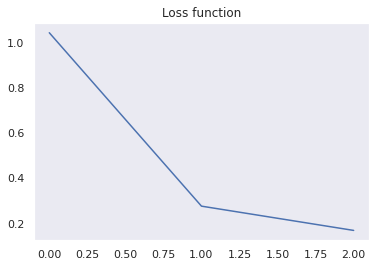

In [172]:
plt.title("Loss function")
sns.lineplot(y=history.history['loss'], x=range(len(history.history['loss'])))

# Evaluate model

In [173]:
model.evaluate(datagen_flow_test)

53/53 [==============================] - 34s 595ms/step - loss: 0.3304 - accuracy: 0.9170 - auc_2: 0.9876


[0.33044323325157166, 0.9169653654098511, 0.9876309633255005]